# Neural Granger Casuality

## Data Loading

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

# 确保PyTorch可以访问GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载数据
data_path = 'Input/processed/dataset_derangement.csv'  # 请替换为正确的路径
data = pd.read_csv(data_path)
# 假设数据已经按照时间和stay_id排序
selected_columns = data.columns.drop(['admission_id', 'hour'])
data = data[selected_columns].values

# # 数据标准化
scaler = StandardScaler()
data = scaler.fit_transform(data)

X = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)
X.shape

Using device: cuda


torch.Size([1, 155304, 12])

## Modeling and Training

In [3]:
from Libs.Models.cMLP import cMLP
# 初始化模型
hidden_layers = [64]  # 可以根据需要调整隐藏层的大小和数量
activation = 'relu'
lag = 5  # 可以根据需要调整
model = cMLP(num_series=X.shape[-1], lag=lag, hidden=hidden_layers, activation=activation).to(device)
model


cMLP(
  (activation): ReLU()
  (networks): ModuleList(
    (0-11): 12 x MLP(
      (activation): ReLU()
      (layers): ModuleList(
        (0): Conv1d(12, 64, kernel_size=(5,), stride=(1,))
        (1): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
      )
    )
  )
)

In [4]:
from Libs.Models.cMLP import train_model_ista, train_model_adam
# 训练模型
lr = 1e-3  # 学习率
lam = 2e-3  # L1正则化系数
lam_ridge = 1e-2  # Ridge正则化系数
max_iter = 5000  # 迭代次数
log_intervel = 1000  # 每隔多少次迭代记录一次损失
train_loss_list = train_model_adam(
    model, X, lam=lam, lam_ridge=lam_ridge, lr=lr, penalty='H', max_iter=max_iter,
    check_every=log_intervel)

----------Iter = 1000----------
Loss = 0.116060
----------Iter = 2000----------
Loss = 0.113190
----------Iter = 3000----------
Loss = 0.112929
----------Iter = 4000----------
Loss = 0.112898
----------Iter = 5000----------
Loss = 0.112890


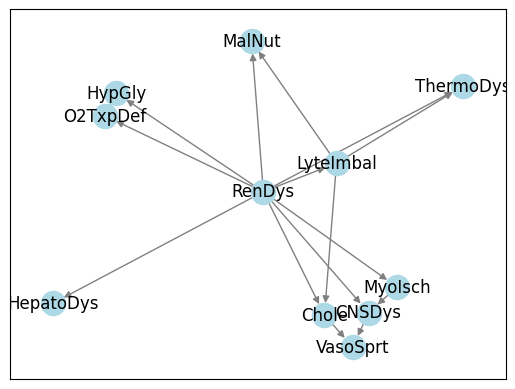

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

GC = [torch.norm(net.layers[0].weight, dim=(0, 2)) for net in model.networks]
GC = torch.stack(GC)
GC_adj = (GC > 0.001).int().cpu().numpy() # 0.001为阈值，可自行设定
n = len(GC_adj)  # 获取邻接矩阵的大小

# 加载数据
data_path = 'Input/processed/dataset_derangement.csv'  # 请替换为正确的路径
data = pd.read_csv(data_path)
labels = data.columns.drop(['admission_id', 'hour']).tolist()
# 创建一个标签映射，将节点的索引映射到标签名
label_dict = {i: labels[i] for i in range(n)}

# 创建图对象
G = nx.DiGraph()

for i in range(n):
    for j in range(i+1, n):  # 只需遍历矩阵上三角来避免重复添加边
        if GC_adj[i, j] == 1:  # 如果i和j之间有边
            G.add_edge(i, j)
            # 为确保节点标签只为实际有边相连的节点设置，可以在此处添加节点，并指定标签
            G.nodes[i]['label'] = labels[i]
            G.nodes[j]['label'] = labels[j]
            
nx.write_graphml(G, 'Output/Results/Granger_Causality_Graph_Derangement.graphml')

# 使用nx.draw_networkx()来绘制图，因为它允许更多自定义，包括节点的标签
pos = nx.spring_layout(G)  # 生成布局
nx.draw_networkx_nodes(G, pos, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels={i: G.nodes[i]['label'] for i in G.nodes()})

plt.show()

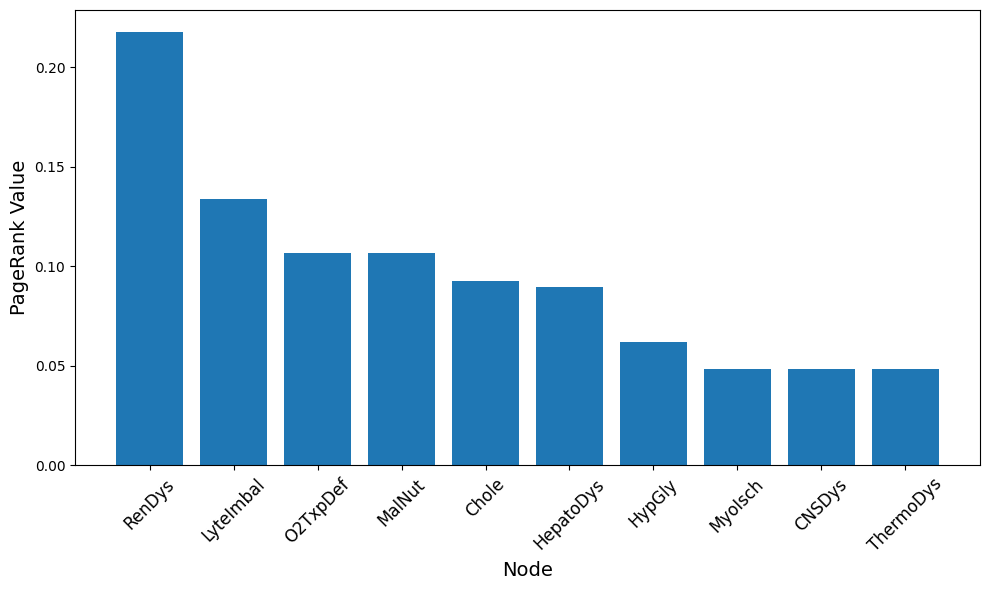

In [9]:
import matplotlib.pyplot as plt
import scienceplots

G = nx.read_graphml('Output/Results/Granger_Causality_Graph_Derangement.graphml')
# Calculate GrootRank values for each node
dangling_nodes = [node for node, out_degree in G.out_degree() if out_degree == 0]
personalization = {}
for node in G.nodes():
    if node in dangling_nodes:
        personalization[node] = 1.0
    else:
        personalization[node] = 0.5
pagerank = nx.pagerank(G, personalization=personalization)
pagerank_values = dict(sorted(pagerank.items(), key=lambda x: x[1], reverse=True))
# Convert PageRank values to a DataFrame for easier analysis
pagerank_df = pd.DataFrame(list(pagerank_values.items()), columns=['Node', 'PageRank'])
pagerank_df['Node'] = [item['label'] for item in dict(G.nodes.data()).values()]
# Sort the DataFrame by PageRank values in descending order
sorted_pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# Take the top 10 nodes by PageRank for visualization
top_pagerank_nodes = sorted_pagerank_df.head(10)

# Create a bar plot for the top 10 nodes
plt.figure(figsize=(10, 6))
plt.bar(top_pagerank_nodes['Node'], top_pagerank_nodes['PageRank'])
plt.xlabel('Node', fontsize=14)
plt.ylabel('PageRank Value', fontsize=14)
plt.xticks(ticks=top_pagerank_nodes['Node'], labels=top_pagerank_nodes['Node'], rotation=45, fontsize=12)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()
